In [59]:
import pybaseball

import pandas as pd
import numpy as np

import sklearn

import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns

pd.set_option('display.max_rows', None)

# Data

In [60]:
d = pybaseball.statcast()
d.shape

start_dt 2025-05-04
end_dt 2025-05-05
This is a large query, it may take a moment to complete


 50%|███████████████████████████████████▌                                   | 1/2 [00:00<00:00,  4.27it/s]/Users/andrewenfield/work/github/mlb_ml/.venv/lib/python3.11/site-packages/pybaseball/datahelpers/postprocessing.py:59: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  data_copy[column] = data_copy[column].apply(pd.to_datetime, errors='ignore', format=date_format)
100%|███████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.81it/s]
/Users/andrewenfield/work/github/mlb_ml/.venv/lib/python3.11/site-packages/pybaseball/statcast.py:85: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_da

(4794, 113)

In [61]:
d[:10]

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,n_thruorder_pitcher,n_priorpa_thisgame_player_at_bat,pitcher_days_since_prev_game,batter_days_since_prev_game,pitcher_days_until_next_game,batter_days_until_next_game,api_break_z_with_gravity,api_break_x_arm,api_break_x_batter_in,arm_angle
281,FC,2025-05-04,89.9,-2.65,5.74,"McGreevy, Michael",607043,700241,field_out,hit_into_play,...,3,4,<NA>,<NA>,<NA>,<NA>,2.1,-0.3,0.3,<NA>
331,SI,2025-05-04,92.8,-2.46,5.66,"McGreevy, Michael",668901,700241,field_out,hit_into_play,...,3,4,<NA>,<NA>,<NA>,<NA>,2.14,1.11,1.11,<NA>
354,FF,2025-05-04,94.7,-2.32,5.79,"McGreevy, Michael",668901,700241,NaN,foul,...,3,4,<NA>,<NA>,<NA>,<NA>,1.29,0.68,0.68,<NA>
391,SI,2025-05-04,91.4,-2.49,5.61,"McGreevy, Michael",668901,700241,NaN,swinging_strike,...,3,4,<NA>,<NA>,<NA>,<NA>,2.6,1.05,1.05,<NA>
414,ST,2025-05-04,83.8,-2.52,5.73,"McGreevy, Michael",668901,700241,NaN,ball,...,3,4,<NA>,<NA>,<NA>,<NA>,3.25,-1.01,-1.01,<NA>
457,FF,2025-05-04,92.7,-2.5,5.77,"McGreevy, Michael",668901,700241,NaN,swinging_strike,...,3,4,<NA>,<NA>,<NA>,<NA>,1.6,0.63,0.63,<NA>
465,SI,2025-05-04,92.3,-2.54,5.62,"McGreevy, Michael",668901,700241,NaN,ball,...,3,4,<NA>,<NA>,<NA>,<NA>,2.12,1.34,1.34,<NA>
517,SI,2025-05-04,92.9,-2.62,5.66,"McGreevy, Michael",624413,700241,strikeout,swinging_strike,...,2,4,<NA>,<NA>,<NA>,<NA>,1.94,0.98,0.98,<NA>
550,SI,2025-05-04,91.3,-2.36,5.75,"McGreevy, Michael",624413,700241,NaN,foul,...,2,4,<NA>,<NA>,<NA>,<NA>,2.32,1.17,1.17,<NA>
557,FF,2025-05-04,92.0,-2.51,5.78,"McGreevy, Michael",624413,700241,NaN,called_strike,...,2,4,<NA>,<NA>,<NA>,<NA>,1.55,0.83,0.83,<NA>


Field documentation is at https://baseballsavant.mlb.com/csv-docs.

Rough quickie initial notes on relevant fields - to start with based on the docs, which don't have all the fields I see in the actual data below:

- pitch_type for ground truth ('pitch_name' maps 1:1 and is it spelled out - i.e. 'FF' and '4-Seam Fastball')
- potentially and/or likely useful for prediction:
    - release_speed
    - pitcher - MLB player ID, for per-pitcher learning
    - pfx_x and pfx_z - horiz/vert movement in feet from catcher's perspective
    - plate_x and plate_z - horiz/vert position of ball when it crosses home place; see a [few](https://billpetti.github.io/baseballr/articles/using_statcast_pitch_data.html) [posts](https://www.reddit.com/r/Sabermetrics/comments/nentrm/can_someone_explain_what_pfx_z_is_from/) for some more context on these and pfx_* .
    - vx0, vy0, vz0 - velocity of pitch in ft/sec, in each dimension at y=50 ft; how diff in info from release_speed?
    - ax, ay, az - acceleration of pitch in ft/sec, in each dimension at y=50 ft
    - effective_speed - 'derived speed based on the extension of the pitcher's release'
    - release_spin_rate - spin rate of pitch
    - spin_axis - spin axis in the 2D X-Z plane in degrees from 0-360, where 180 is a 'pure backspin fastball' and 0 is a 'pure topsping - 12-6 - curveball'
    - release_extension - 'release extension' in feet
- maybe useful, for ex w/ some addtl preprocessing or other work, or given more thought:
    - release_pos_x and release_pos_z
    - if_fielding_alignment/of_fielding_alignment - infield/outfield fielding alignment at time of pitch
    - stand - side of plate batter is standing
    - p_throws - hand pitcher throws with
    - balls - pre-pitch number of balls in count
    - strikes - pre-pitch number of strikes in count
    - game_year - year game took place (change over time?)
    - outs_when_up - pre-pitch number of outs
    - inning - pre-pitch inning number
    - on_1b, on_2b, on_3b - MLB player IDs of runners on base
    - release_pos_y - 'release position' of pitch in feet from catcher's perspective
    - pitch_number - total pitch number of the plate appearance
    - bat_score and fld_score - pre-pitch batting/fielding team scores

Seems like there are a relatively small number of fields that most directly relate to the kind of pitch - things like release speed, movement, and spin rate/axis, as well as the actual pitcher given that folks typically throw different pitches and with different distributions over the pitches thrown - and also a potentially somewhat larger set of fields that could be correlated with changes in pitches thrown/give hints at what a pitch could be/likelihood of a particular pitch being thrown in different cases - like the game situation (runners on base, balls/strikes, etc.).   

In [62]:
d.iloc[0]

pitch_type                                                                         FC
game_date                                                         2025-05-04 00:00:00
release_speed                                                                    89.9
release_pos_x                                                                   -2.65
release_pos_z                                                                    5.74
player_name                                                         McGreevy, Michael
batter                                                                         607043
pitcher                                                                        700241
events                                                                      field_out
description                                                             hit_into_play
spin_dir                                                                         <NA>
spin_rate_deprecated                                  

In [63]:
d['pitch_type'].value_counts(dropna=False)

pitch_type
FF    1354
SI     957
SL     697
CH     545
ST     383
CU     343
FC     311
FS     125
KC      72
CS       5
PO       1
SV       1
Name: count, dtype: int64

<Axes: xlabel='release_speed', ylabel='effective_speed'>

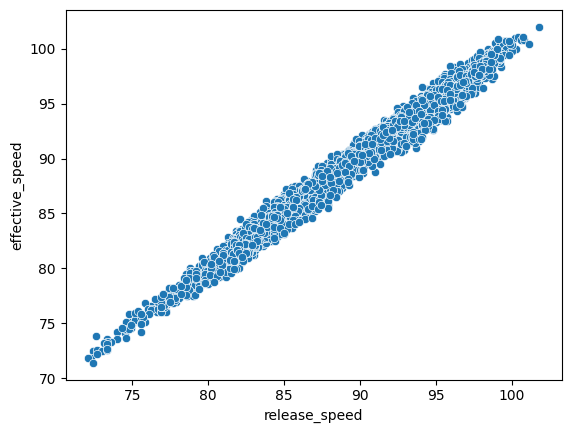

In [64]:
sns.scatterplot(x=d['release_speed'], y=d['effective_speed'])

In [65]:
d.groupby(['pitch_name','pitch_type']).size()

pitch_name       pitch_type
4-Seam Fastball  FF            1354
Changeup         CH             545
Curveball        CU             343
Cutter           FC             311
Knuckle Curve    KC              72
Pitch Out        PO               1
Sinker           SI             957
Slider           SL             697
Slow Curve       CS               5
Slurve           SV               1
Split-Finger     FS             125
Sweeper          ST             383
dtype: int64

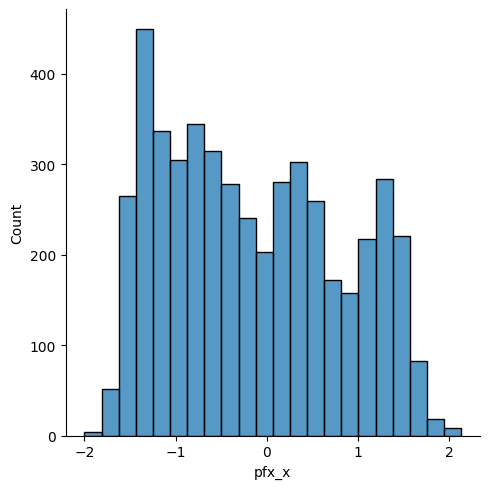

In [66]:
sns.displot(d['pfx_x'])

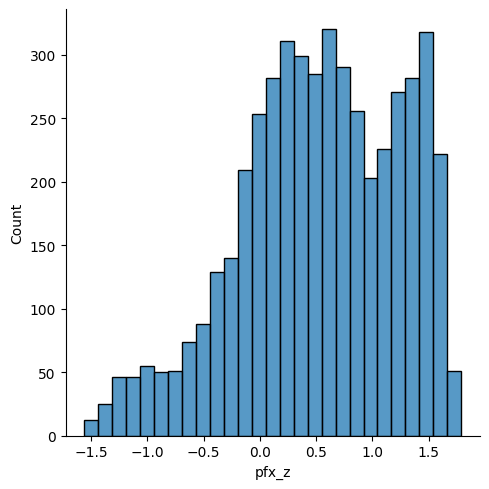

In [67]:
sns.displot(d['pfx_z'])

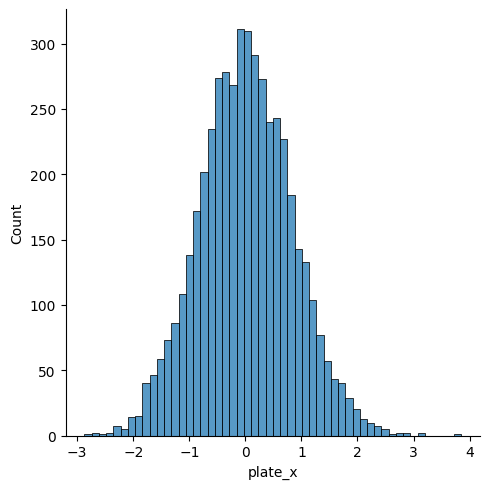

In [68]:
sns.displot(d['plate_x'])

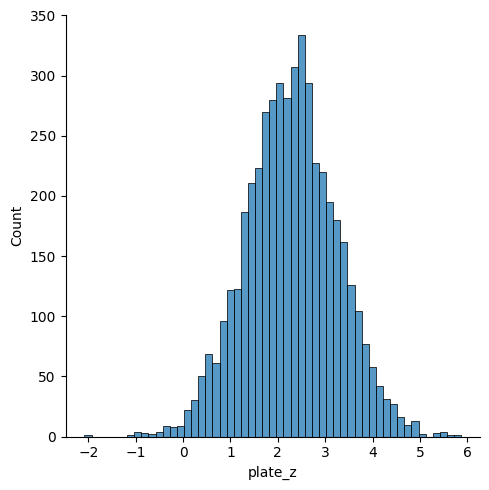

In [69]:
sns.displot(d['plate_z'])

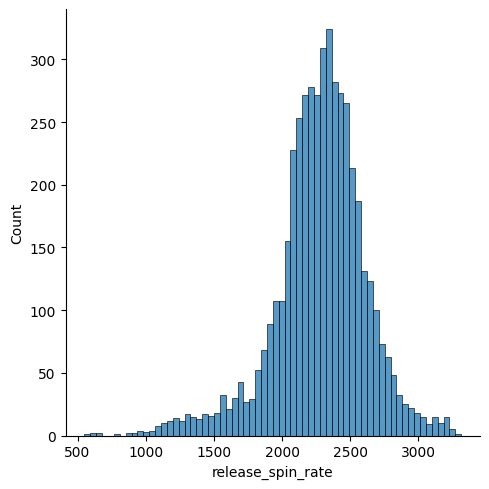

In [70]:
sns.displot(d['release_spin_rate'])

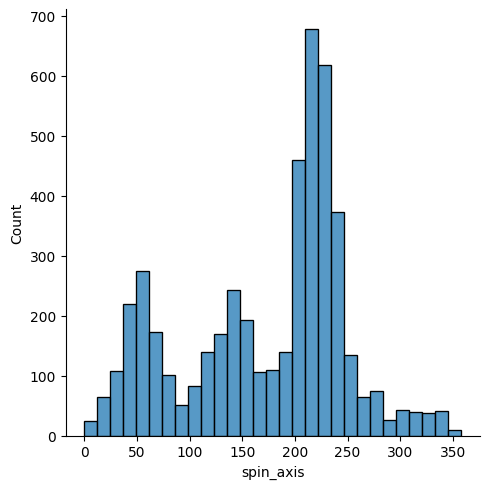

In [71]:
sns.displot(d['spin_axis'])

# Preprocessing

In [72]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [73]:
x_feature_names = ['release_speed', 'pfx_x', 'pfx_z', 'release_spin_rate', 'spin_axis']
y_feature_name = 'pitch_name'

In [74]:
# torch wants integer indices for categorical labels, not the strings we have
y_label_encoder = LabelEncoder()
y_encoded = y_label_encoder.fit_transform(d[y_feature_name])
d[y_feature_name][:5], y_encoded[:5]

(281             Cutter
 331             Sinker
 354    4-Seam Fastball
 391             Sinker
 414            Sweeper
 Name: pitch_name, dtype: object,
 array([ 3,  6,  0,  6, 11]))

In [75]:
X_train, X_test, y_train, y_test = train_test_split(d[x_feature_names], y_encoded, test_size=0.2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(3835, 5) (959, 5) (3835,) (959,)


In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [77]:
X_train['release_speed'].describe()

count       3835.0
mean     89.581773
std       5.635665
min           72.1
25%           85.1
50%           90.7
75%           94.2
max          101.8
Name: release_speed, dtype: Float64

In [78]:
X_train_scaled[:,0].mean(), X_train_scaled[:,0].std()

(np.float64(2.2603967082850645e-15), np.float64(1.0))

# First rough quick cut at a DNN

In [86]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader 

In [80]:
count_input_features = len(x_features)
count_output_classes = len(d[y_feature].unique())
count_input_features, count_output_classes

(5, 12)

In [52]:
class PitchMLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.2),

            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.2),

            nn.Linear(64, output_dim)
            # no softmax in the model, as the torch CrossEntropyLoss expects raw logits
        )

    def forward(self, x):
        return self.model(x)

The below is quick for initial exploratory understanding - I think in practice I'd want to do something like a custom DataSet class that encapsulates things like encoding and scaling.

In [89]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [95]:
model = PitchMLP(input_dim=count_input_features, output_dim=count_output_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print(model)
print(f'Trainable params: {sum(p.numel() for p in model.parameters())}')
print()

for epoch in range(25):
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f'Epoch {epoch+1}: loss = {total_loss:.4f}')

PitchMLP(
  (model): Sequential(
    (0): Linear(in_features=5, out_features=128, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.2, inplace=False)
    (8): Linear(in_features=64, out_features=12, bias=True)
  )
)
Trainable params: 10188

Epoch 1: loss = 135.2249
Epoch 2: loss = 80.7308
Epoch 3: loss = 73.2386
Epoch 4: loss = 67.2423
Epoch 5: loss = 64.0596
Epoch 6: loss = 61.7947
Epoch 7: loss = 60.8238
Epoch 8: loss = 59.1616
Epoch 9: loss = 58.4342
Epoch 10: loss = 56.3634
Epoch 11: loss = 54.6957
Epoch 12: loss = 54.1339
Epoch 13: loss = 53.8747
Epoch 14: loss = 53.6791
Epoch 15: loss = 51.2050
Epoch 16: loss = 51.4488
Epoch 17: loss = 50.6560
Epoch 18: loss = 50.6607
Epoch 19: loss = 49.8487

Perhaps want to add periodic (or every time?) checking w/ the test set, and plot curves, next.